<a href="https://colab.research.google.com/github/Ssamikarann/US-population/blob/master/USPopulation_Sktime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install sktime

     |████████████████████████████████| 5.5MB 2.5MB/s 
     |████████████████████████████████| 9.5MB 43.8MB/s 
     |████████████████████████████████| 6.8MB 37.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

In [ ]:
from google.colab import files

uploaded = files.upload()



Saving POP.csv to POP (2).csv
Saving POPH.csv to POPH (2).csv


In [ ]:
df = pd.read_csv('POPH.csv')

In [ ]:
df

,realtime_start,value,date,realtime_end
0,2019-12-06,76094000,1900-01-01,2019-12-06
1,2019-12-06,77584000,1901-01-01,2019-12-06
2,2019-12-06,79163000,1902-01-01,2019-12-06
3,2019-12-06,80632000,1903-01-01,2019-12-06
4,2019-12-06,82166000,1904-01-01,2019-12-06
...,...,...,...,...
95,2019-12-06,262803276,1995-01-01,2019-12-06
96,2019-12-06,265228572,1996-01-01,2019-12-06
97,2019-12-06,267783607,1997-01-01,2019-12-06
98,2019-12-06,270248003,1998-01-01,2019-12-06


In [ ]:
df[['value','date']].isnull().sum()  # checking for null values

value    0
date     0
dtype: int64

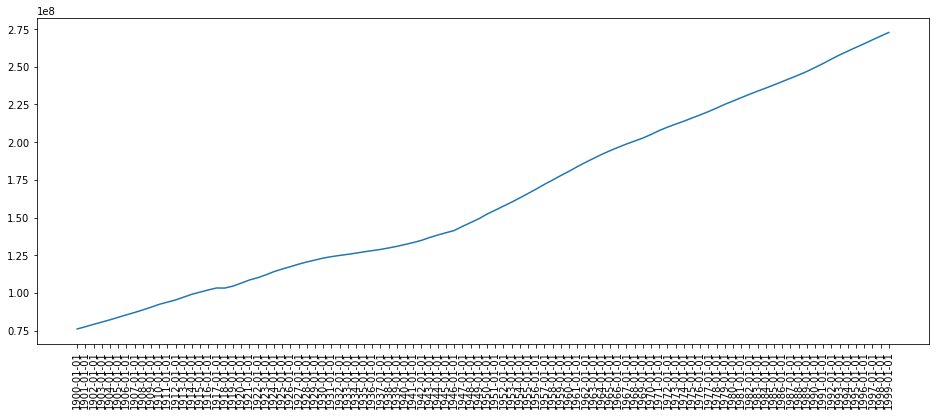

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df['date'],df['value'],label='Us-population')
plt.xticks(rotation=90)
plt.show()



### Specifying the forecasting task
Next we will define a forecasting task.

We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.
We can split the data as follows:

### Splitting Dataset

64 36


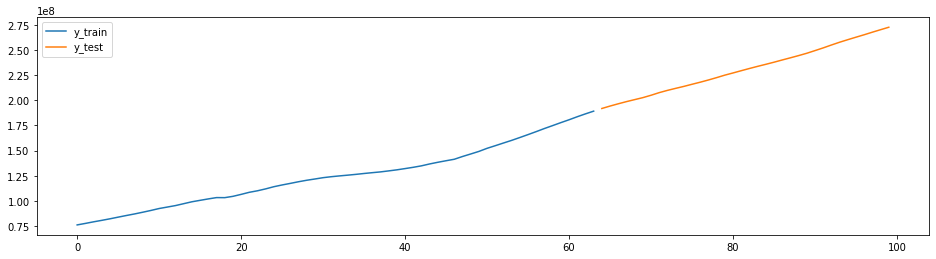

In [ ]:
y= df['value']
y_train, y_test = temporal_train_test_split(y, test_size=36)  # similar to sklearn but splitting is based on shuffle = False
plot_ys(y_train, y_test, labels=["y_train", "y_test"]) # similar to matplotlib
print(y_train.shape[0], y_test.shape[0])

####Forecasting Horizon
 We can specify the forecasting horizon as a simple numpy array of the steps ahead, relative to the end of the training series:



In [ ]:

fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

### Naive Forecaster - we will use seasonal last

0.21559472117276055

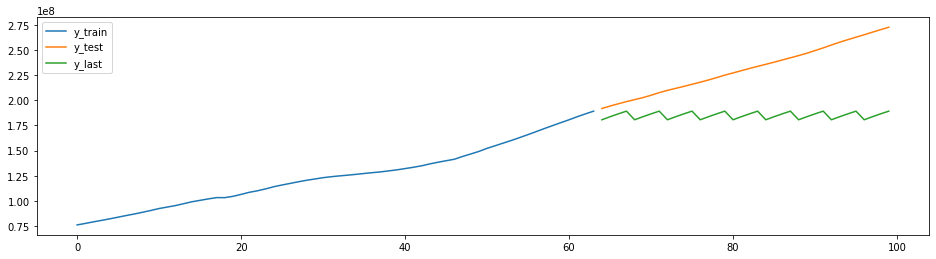

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy='seasonal_last',sp=4) # initializing
forecaster.fit(y_train)
y_last = forecaster.predict(fh) 
plot_ys(y_train,y_test,y_last,labels=['y_train','y_test','y_last'])
smape_loss(y_last,y_test)



## Using AutoArima 
In sktime,  pmdarima is used, a package for automatically selecting the best ARIMA model. This since searches over a number of possible model parametrisations, it may take a bit longer.

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.4MB/s 
     |████████████████████████████████| 8.7MB 6.1MB/s 
     |████████████████████████████████| 2.1MB 44.1MB/s 
     |████████████████████████████████| 808kB 42.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0


0.0331982941944013

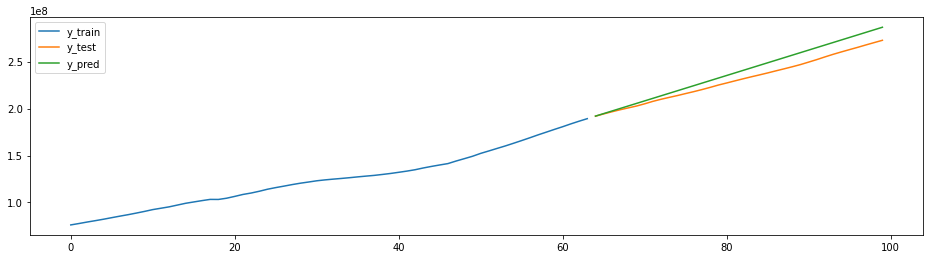

In [ ]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Using Ensemble Method

0.030288617844259427

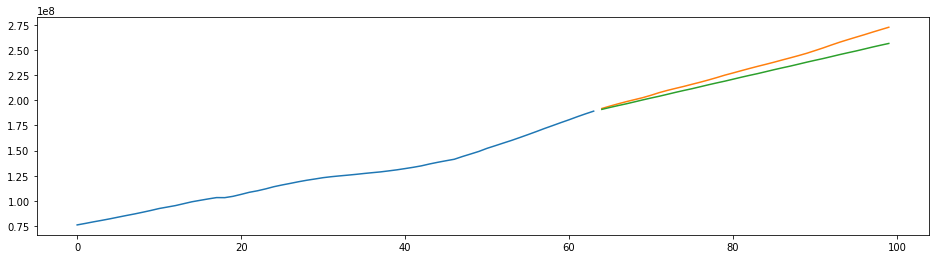

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=4)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=4)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=4))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
smape_loss(y_test, y_pred)

### Detrending

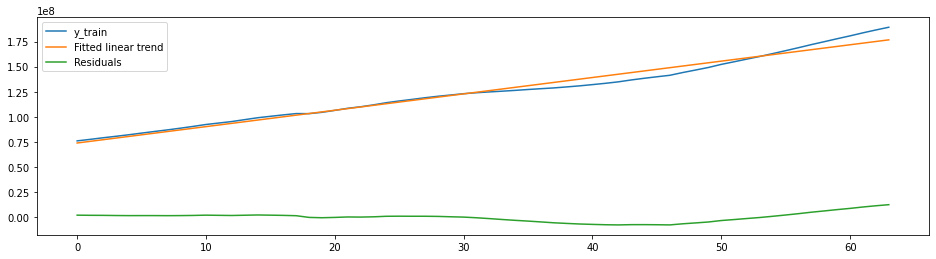

In [ ]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

## Tuning and CV

Similar to temporal splitting, CV does a sliding window splitting



In [ ]:

from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=10, start_with_window=True)
for input_window, output_window in cv.split(y_train.iloc[:20]):
    print(input_window, output_window)


[0 1 2 3 4 5 6 7 8 9] [10]
[ 1  2  3  4  5  6  7  8  9 10] [11]
[ 2  3  4  5  6  7  8  9 10 11] [12]
[ 3  4  5  6  7  8  9 10 11 12] [13]
[ 4  5  6  7  8  9 10 11 12 13] [14]
[ 5  6  7  8  9 10 11 12 13 14] [15]
[ 6  7  8  9 10 11 12 13 14 15] [16]
[ 7  8  9 10 11 12 13 14 15 16] [17]
[ 8  9 10 11 12 13 14 15 16 17] [18]
[ 9 10 11 12 13 14 15 16 17 18] [19]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import RecursiveRegressionForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetri

0.20066453911636317

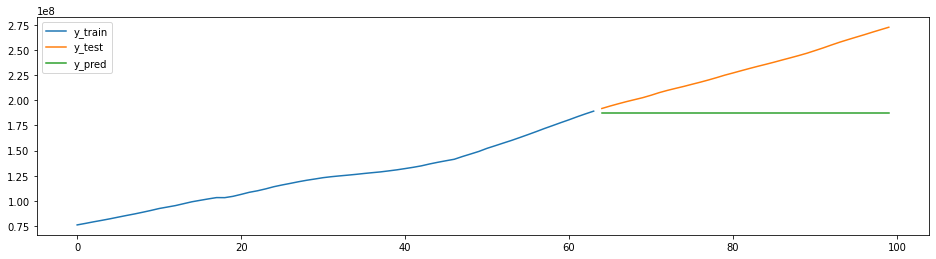

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Pipelining

0.05677584957136875

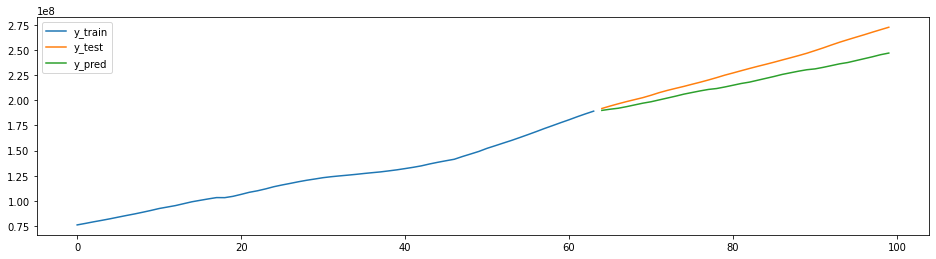

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster,ReducedRegressionForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)
